In [1]:
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

%run "..//JM_custom_figs.py"

C:\Github\Distraction-Paper\JM_custom_figs.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence


In [2]:
datafolder = "C:\\Github\\Distraction-Paper\\data\\"
figfolder = "C:\\Github\\Distraction-Paper\\figs\\"
outputfolder = "C:\\Github\\Distraction-Paper\\output\\"

try:
    pickle_in = open(datafolder + "distraction_data_with_snips.pickle", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[modDict, disDict, habDict] = dill.load(pickle_in)

In [3]:
rat = 'thph1.1'
d = modDict[rat]
d.keys()

dict_keys(['rat', 'blue', 'uv', 'fs', 'filt', 'tick', 'licks', 'licks_off', 'distractors', 'distracted', 'notdistracted', 'd_bool_array', 'pdp', 'pre_dp', 'lickdata', 'snips_distractors', 'snips_distracted', 'snips_not-distracted'])

In [4]:
def plot_trials(ax, d, rat, key, signal):
    trials = d[rat][key][signal]
    for trial in trials:
        ax.plot(trial, color='k', alpha=0.1)
    

In [5]:
def plot_avg_of_multiple_days(ax, ds, rat, key, signal):
    """Plots the average of the same signal from multiple days (contained in separate dictionaries)"""
    
    colors=['grey', 'blue', 'xkcd:light blue']
    
    for d, color in zip(ds, colors):
        trials = d[rat][key][signal]
        ax.plot(np.mean(trials, axis=0), color=color)

In [6]:
def plot_bars(ax, ds, rat, key, signal, bins=[100, 130], calctype='auc'):
    for idx, d in enumerate(ds):
    
        trials = d[rat][key][signal]

        if calctype == 'auc':
            trials_out = [np.trapz(trial[bins[0]:bins[1]])*0.1 for trial in trials]

        ax.bar(idx, np.mean(trials_out))

        ax.scatter([idx]*len(trials_out), trials_out)

In [7]:
def plot_raster(ax, d, rat, pre = 5, post = 10,
                         sortevents=None, sortdirection='ascending',
                         title=''):
    
    timelock = d[rat]['distractors']
    events = d[rat]['licks']
    sortevents = d[rat]['pdp']
    
    if sortevents != None:
        if len(timelock) != len(sortevents):
            print('Length of sort events does not match timelock events; no sorting')

        if len(timelock) == (len(sortevents) + 1):
            sortevents.append(0)
            
            if sortdirection == 'ascending':
                sortOrder = np.argsort(sortevents)
            else:
                sortOrder = np.argsort(sortevents)[::-1]
                
            timelock = [timelock[i] for i in sortOrder]    
        else:
            if sortdirection == 'ascending':
                sortOrder = np.argsort(sortevents)
            else:
                sortOrder = np.argsort(sortevents)[::-1]
                
            timelock = [timelock[i] for i in sortOrder]
    
    rasterData = [[] for i in timelock]
    
    for i,x in enumerate(timelock):
        rasterData[i] = [j-x for j in events if (j > x-pre) & (j < x+post)]
 
    for ith, trial in enumerate(rasterData):

        xvals = [x for x in trial] 
        yvals = [1+ith] * len(xvals)
        
        pdplist = [lick for lick in xvals if lick > 0 and lick < 1]
        if len(pdplist) > 0:
            ax.scatter(xvals, yvals, marker=',', s=1, color='k')
        else:
            ax.scatter(xvals, yvals, marker=',', s=1, color='xkcd:light blue')
    
    ax.set_title(title)
    set_raster_axes(ax)

In [8]:
def set_raster_axes(ax, length=1, offset=1, ypos=0):
    """Prepares axes for raster plots including adding scale bar"""
     
    # Turns off spines and x ticks
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    
    # Gets x coordinates for scale bar
    xmin=ax.get_xlim()[0]
    x0=xmin+offset
    x1=xmin+offset+length
    
    # Sets up a transform for x in data coords and y in axis coords
    trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)

    # Plots line using x and y and transform
    line = mpl.lines.Line2D([x0, x1], [ypos, ypos], lw=2., color='k', transform=trans)
    line.set_clip_on(False)
    ax.add_line(line)
    
    # Adds text below line
    ax.text((x1-length/2), ypos-0.02, '{} s'.format(length), va='top', ha='center', transform=trans)
    
    # Adds triangle to show distractor
    ax.plot(0, 1., marker="v", markersize=6, color='grey', clip_on=False, transform=trans)

In [9]:
def plot_trials_and_avg(ax, d, rat, key, signal, plot_avg=True, plot_trials=False):
    """Plots all trials and/or the average from a single day."""
    
    trials = d[rat][key][signal]
    
    if plot_trials:
        for trial in trials:
            ax.plot(trial, color='k', alpha=0.1)
        
    if plot_avg:
        mean = np.mean(trials, axis=0)
        ax.plot(mean, color='k')

In [10]:
def shadedError(ax, yarray, linecolor='black', errorcolor = 'xkcd:silver', linewidth=1):
    yarray = np.array(yarray)
    y = np.mean(yarray, axis=0)
    yerror = np.std(yarray)/np.sqrt(len(yarray))
    x = np.arange(0, len(y))
    ax.plot(x, y, color=linecolor, linewidth=1)
    ax.fill_between(x, y-yerror, y+yerror, color=errorcolor, alpha=0.4)
    
    return ax

In [22]:
def set_photometry_axes(ax):
    """Alters axes to match photometry style."""
#     ax.set_xlabel('Time from distractor (s)')
#     ax.set_xticks([0, 100, 200, 300])
#     ax.set_xticklabels(['-10', '0', '10', '20'])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.set_xticks([])

In [23]:
def plot_single_avg(ax, d, rat, key, signal):
    """Plots average of photometry data using single condition"""
    
    trials = d[rat][key][signal]
    if len(trials) > 0:
        shadedError(ax, trials)
    
    set_photometry_axes(ax)

In [24]:
def plot_multiple_avgs(ax, d, rat, keys, signal):
    """Plots averages from multiple conditions taken from same day (dictionary)"""
    
    ypos = 1
    
    for key, color, legend in zip(keys,
                          ['grey', 'red'],
                                 ['not distracted', 'distracted']):
        trials = d[rat][key][signal]
        if len(trials) > 0:
            shadedError(ax, trials, linecolor=color)
        text = f"{legend} ({len(trials)})"
        ax.text(1, ypos, text, color=color, ha='right', va='top', transform=ax.transAxes)
        ypos=ypos-0.1
   
    set_photometry_axes(ax)

In [14]:
def time2samples(d):
    """Creates time2samples (t2s) map allowing events to be easily converted to sample number in photometry data"""
    
    d['t2sMap'] = np.linspace(1, len(d['blue']), len(d['blue'])) / d['fs']

def event2sample(EOI, t2sMap):
    """Uses map from photometry data to transfrom timestamps into sample numbers"""
    idx = (np.abs(t2sMap - EOI)).argmin()   
    return idx

In [15]:
def plot_full_signal(ax, d, rat, sigs, colors, buffer=0.1, plot_events=True):
    """
    This function plots the full photometry signal(s) from the session.
    
    """
    bounds=[]
    
    for idx, sig in enumerate(sigs):
        data=d[rat][sig]
        ax.plot(data, color=colors[idx])
        
        n_points=len(data)
        middle_portion = data[int(n_points*0.1):int(n_points*0.9)]
        bounds.append([np.max(middle_portion), np.min(middle_portion)])
    
    min_val, max_val = np.min(bounds), np.max(bounds)
    ax.set_ylim([min_val - np.abs(min_val)*buffer, max_val + np.abs(max_val)*buffer])
        
    ax.set_xticks([])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Sets up a transform for x in data coords and y in axis coords
    trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)
    
    if plot_events:
        for marker, color, ypos in zip(['distracted', 'notdistracted'],
                                 ['red', 'grey'],
                                      [1, 1.1]):
            events = [event*d[rat]['fs'] for event in d[rat][marker]]
            ax.scatter(events, [ypos]*len(events), s=15, edgecolors=color, facecolors='none', clip_on=False, transform=trans)

In [37]:
def make_heatmap(ax, d, rat, key, signal, events=[], sortevents=[], event_direction='post', ylabel='Trials'):
    
    data = d[rat][key][signal]
    
    if len(sortevents)> 0:
        sort_order = np.argsort(sortevents)
        data = [data[i] for i in sort_order]
        events = [events[i] for i in sort_order]
        
    if event_direction == 'pre':
        events = [-event for event in events]
    
    ntrials = np.shape(data)[0]
    xvals = np.linspace(-4.9,15,200)
    yvals = np.arange(1, ntrials+2)
    xx, yy = np.meshgrid(xvals, yvals)
    
    mesh = ax.pcolormesh(xx, yy, data, cmap=heatmap_color_scheme, shading = 'flat')
    
    if len(events) > 0:
        ax.vlines(events, yvals[:-1], yvals[1:], color='w')
    else:
        print('No events')
        
    ax.set_ylabel(ylabel)
    ax.set_yticks([1, ntrials])
    ax.set_xticks([])
    ax.invert_yaxis()
    ax.spines['bottom'].set_visible(False)
    
    ax.set_xlim([-4.9,15])
    mesh.set_clim(clims)
    
    return ax, mesh

KeyError: 'thph2.8'

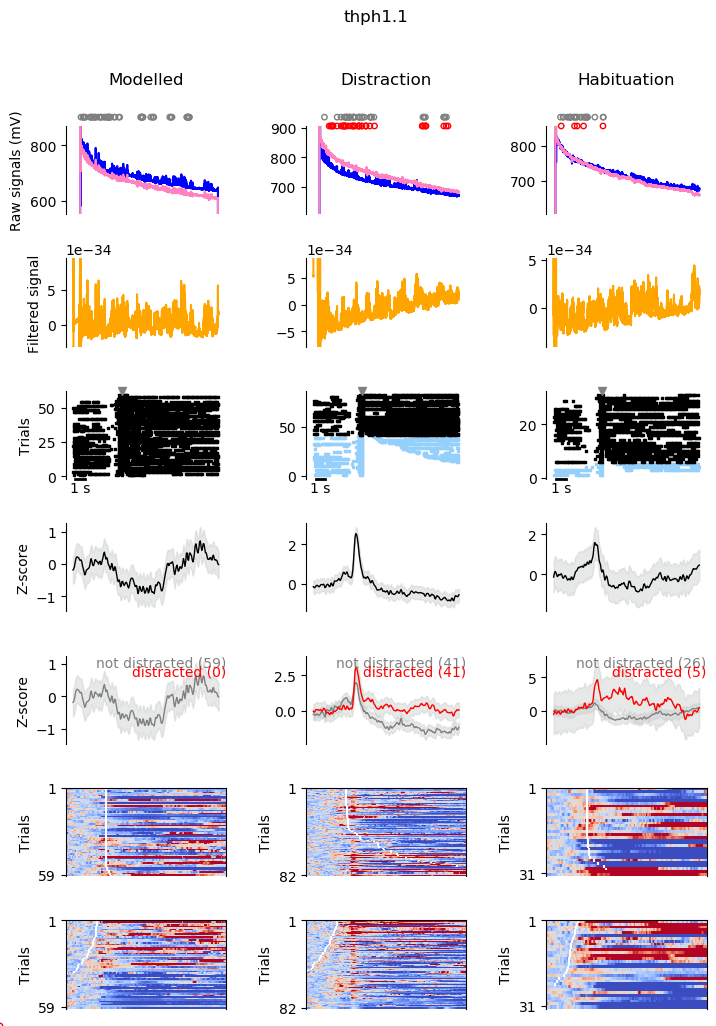

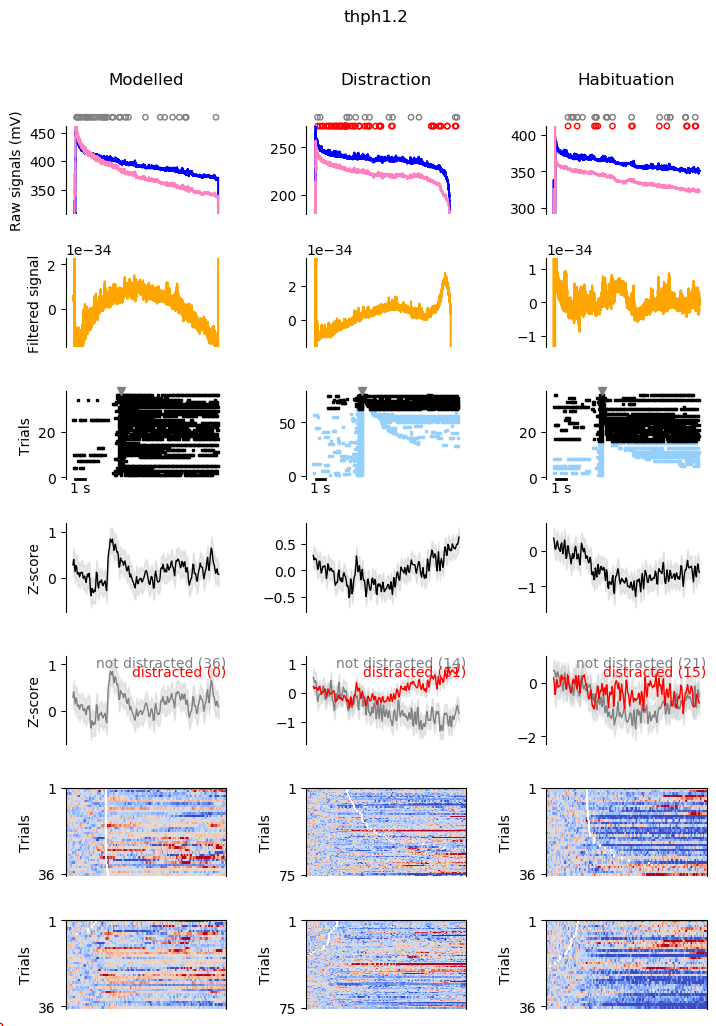

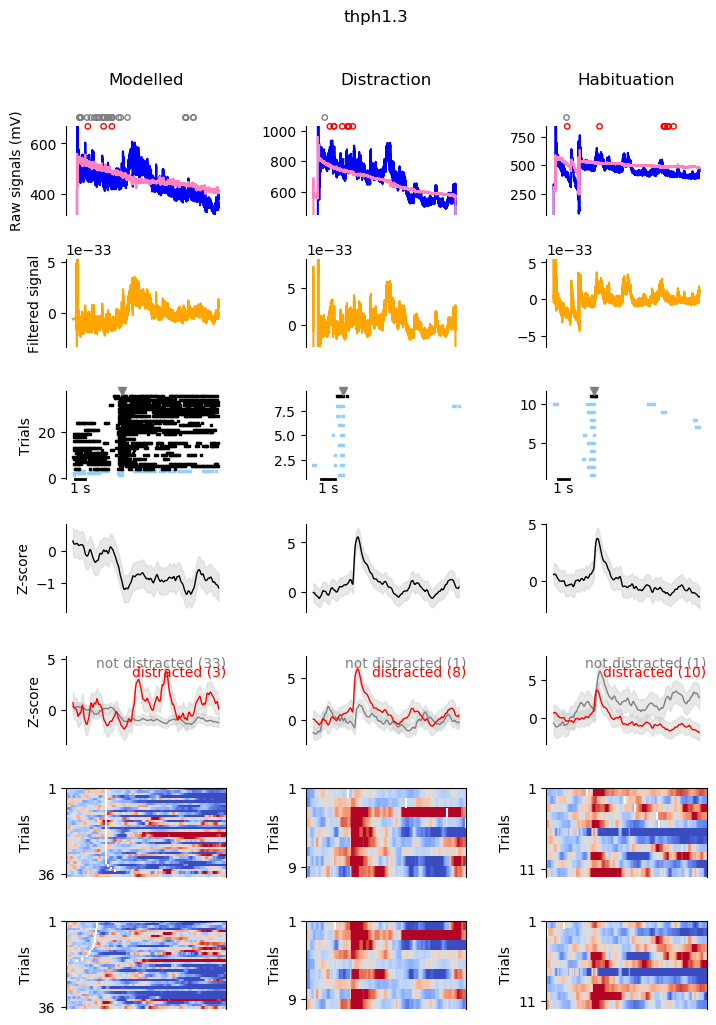

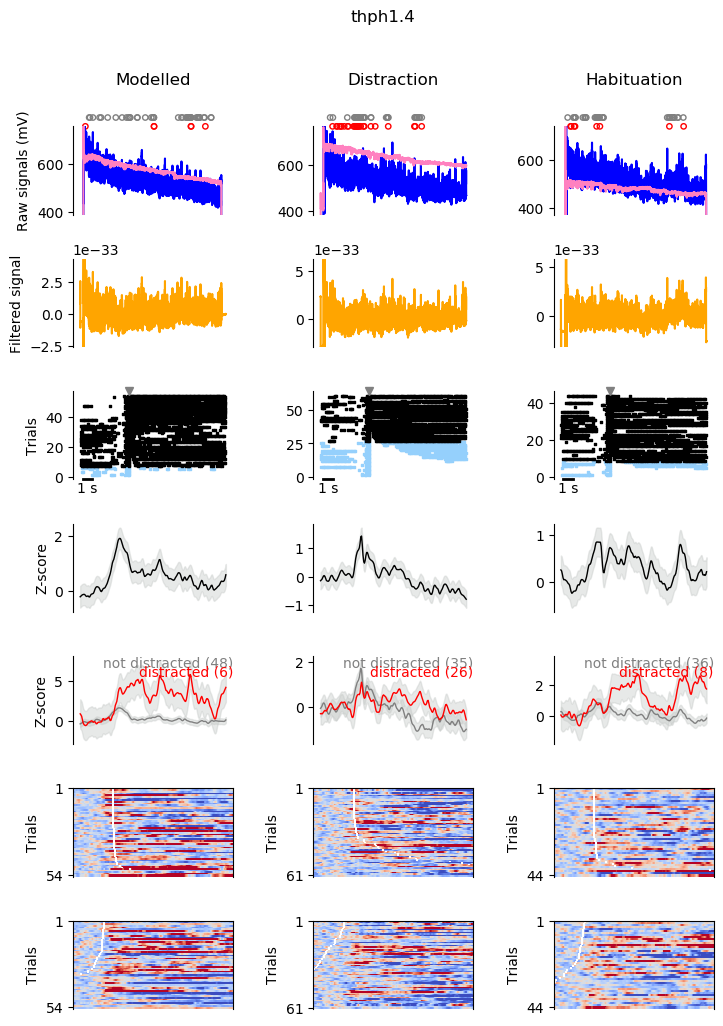

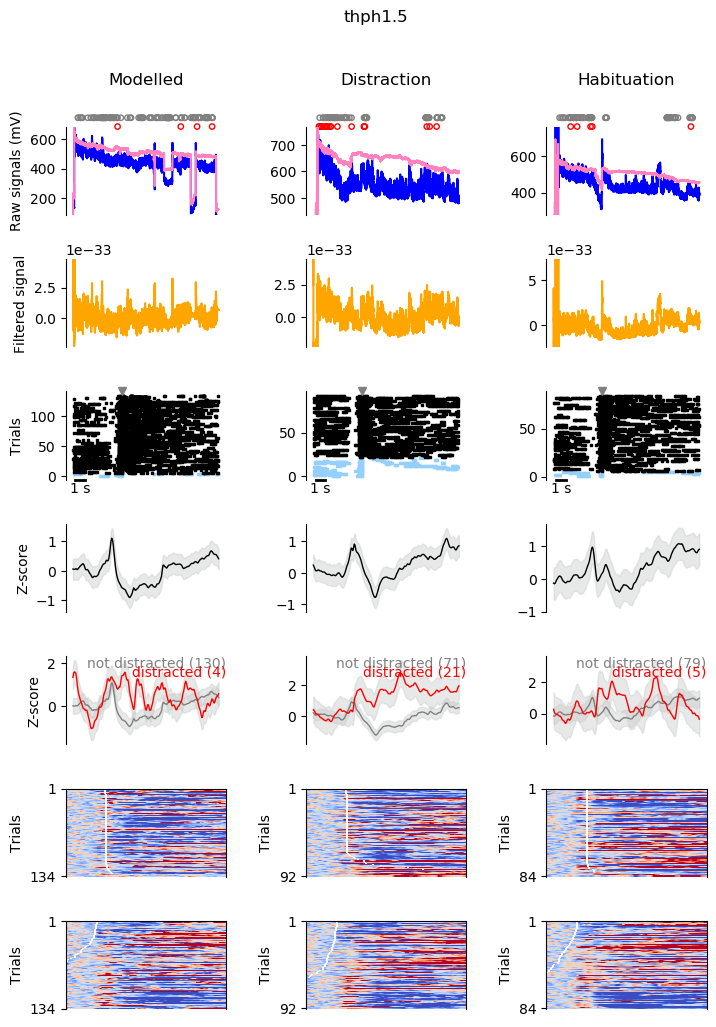

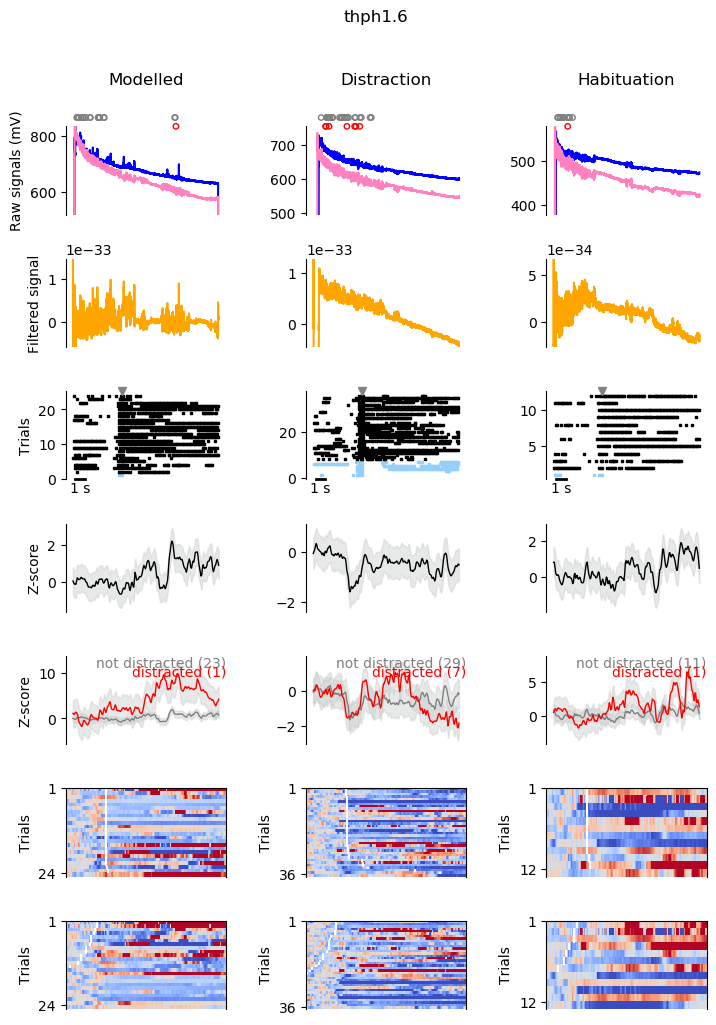

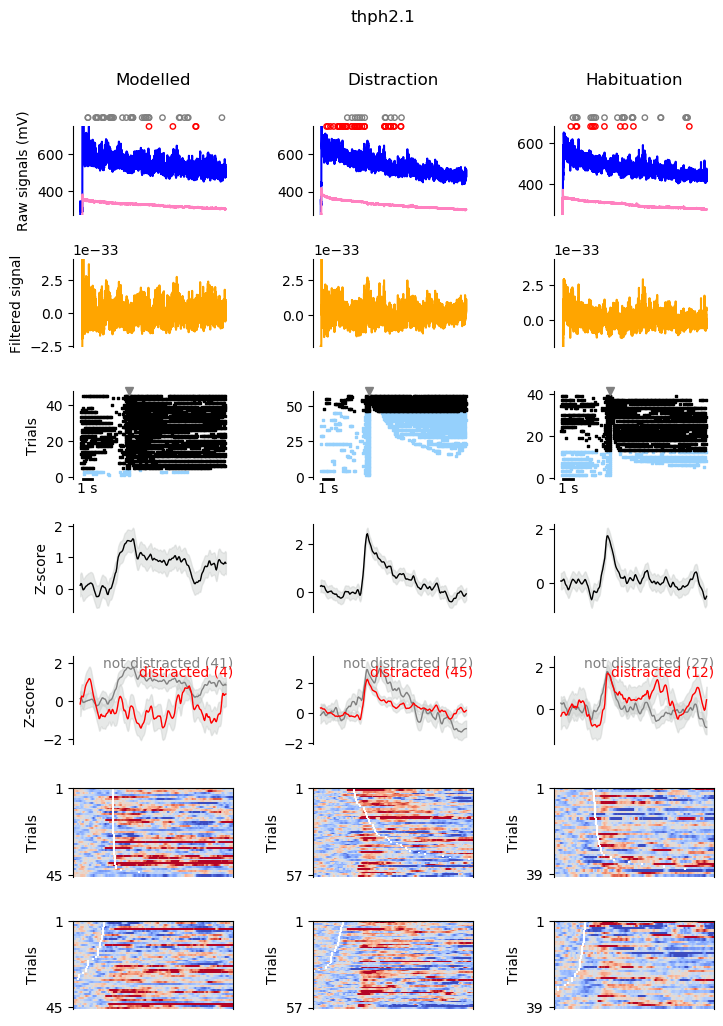

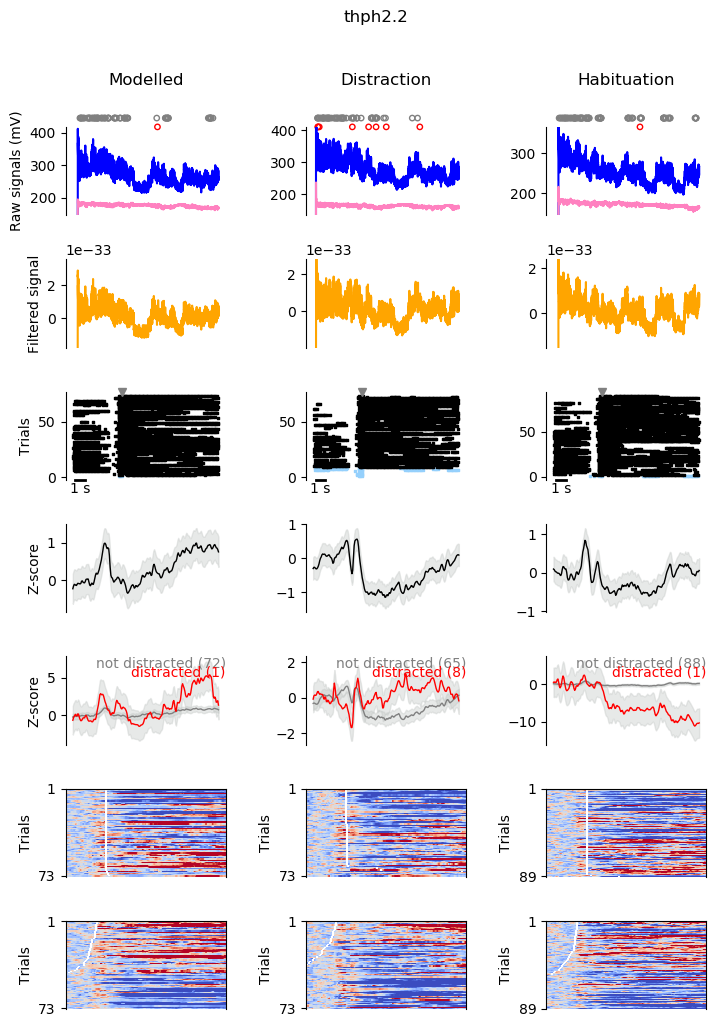

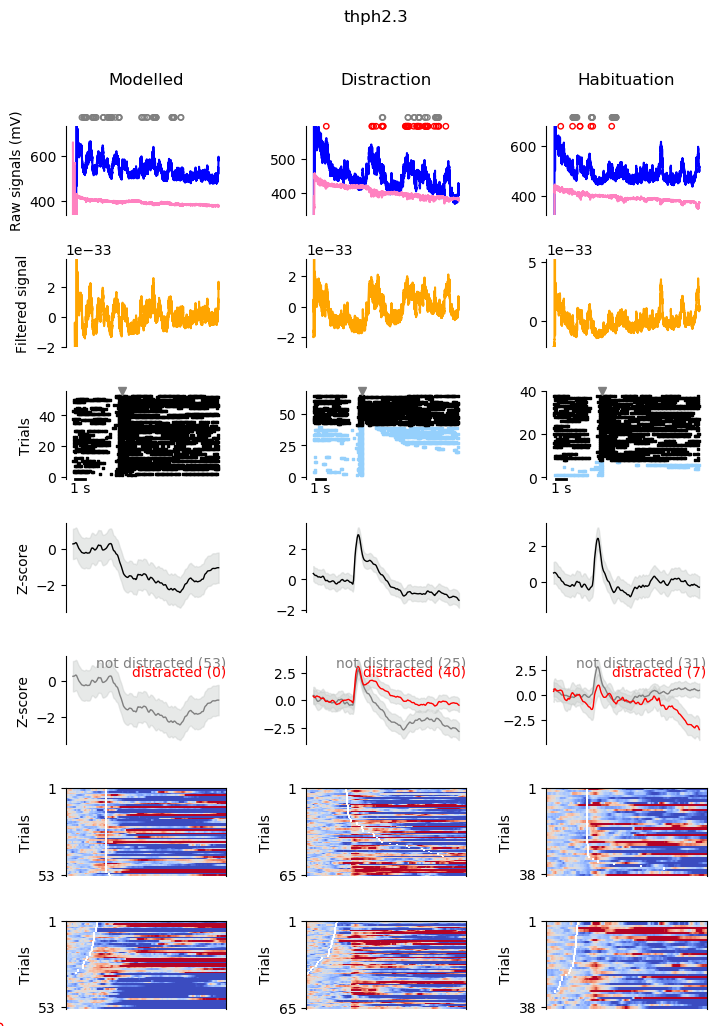

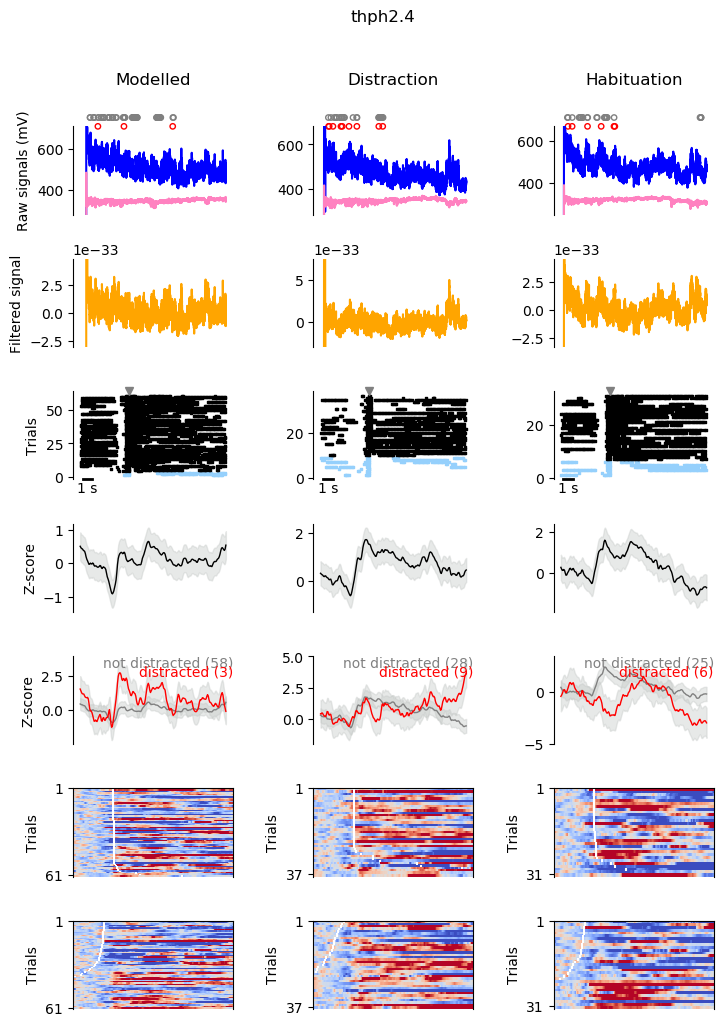

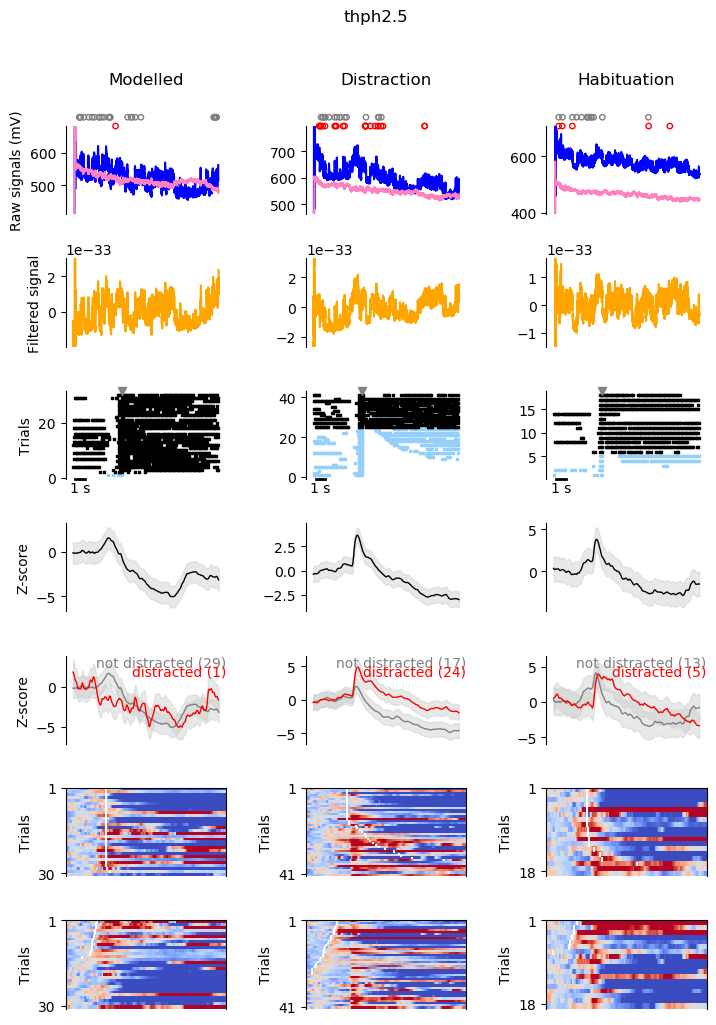

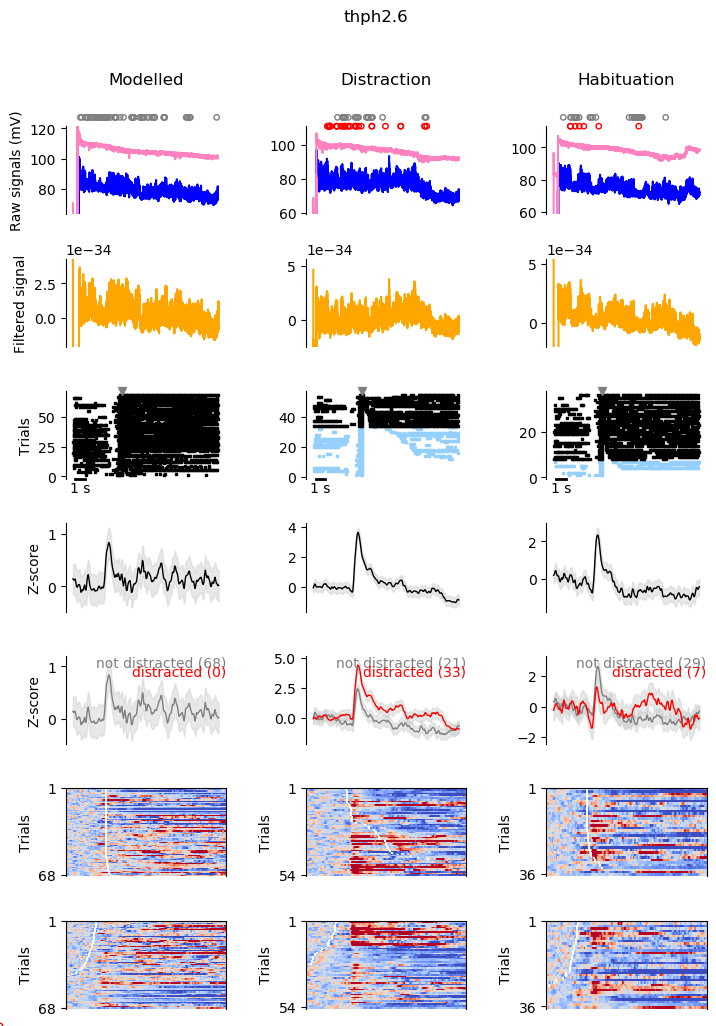

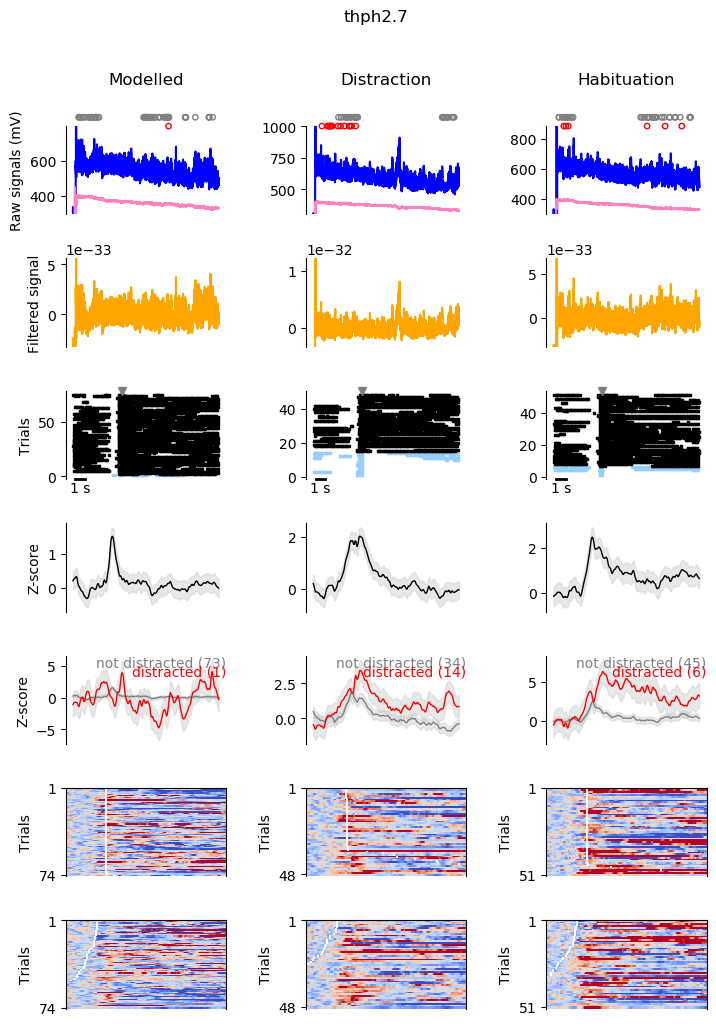

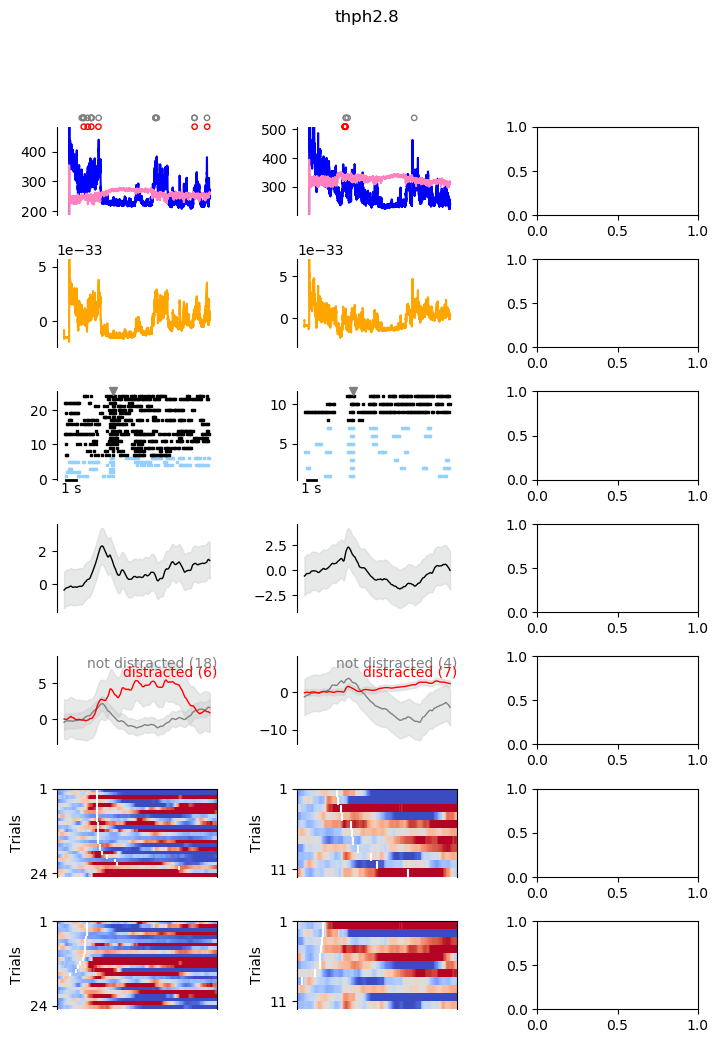

In [40]:
# rat = 'thph1.1'

heatmap_color_scheme = 'coolwarm'
clims = [-3,4]

rats = modDict.keys()
# rats = ['thph1.1']

for rat in rats:
    full_signals = ['blue', 'uv']
    key='snips_distractors'
    keys = ['snips_not-distracted', 'snips_distracted']
    signal='filt_z'

    f, ax =plt.subplots(nrows=7, ncols=3, figsize=(8.27, 11.69), dpi=100)
    f.subplots_adjust(wspace=0.5, hspace=0.5)
    f.suptitle(rat)

    for idx, d in enumerate([modDict, disDict, habDict]):
        time2samples(d[rat])
        plot_full_signal(ax[0][idx], d, rat, full_signals, ['blue', 'xkcd:pink'])

        plot_full_signal(ax[1][idx], d, rat, ['filt'], ['orange'], buffer=0.5, plot_events=False)

        plot_raster(ax[2][idx], d, rat, sortdirection='dec')

        plot_single_avg(ax[3][idx], d, rat, key, signal)

        plot_multiple_avgs(ax[4][idx], d, rat, keys, signal)
        
        make_heatmap(ax[5][idx], d, rat, key, signal, events=d[rat]['pdp'], sortevents=d[rat]['pdp'])
        
        make_heatmap(ax[6][idx], d, rat, key, signal, events=d[rat]['pre_dp'], sortevents=d[rat]['pre_dp'], event_direction='pre')

    ax[0][0].set_ylabel('Raw signals (mV)')
    ax[1][0].set_ylabel('Filtered signal')
    ax[2][0].set_ylabel('Trials')
    ax[3][0].set_ylabel('Z-score')
    ax[4][0].set_ylabel('Z-score')

    pad=30
    ax[0][0].set_title('Modelled', pad=pad)
    ax[0][1].set_title('Distraction', pad=pad)
    ax[0][2].set_title('Habituation', pad=pad)

    f.savefig(outputfolder+rat+".pdf")

In [ ]:
rat = 'thph1.1'
pdf_pages = PdfPages(outputfolder + rat + '.pdf')

In [ ]:
pdf_pages.savefig(photoFig)

In [ ]:
pdf_pages.close()
plt.close('all')